In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.applications import ResNet50
import os
from sklearn.metrics import roc_curve, roc_auc_score
import cv2
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras
import tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D,Dropout,MaxPooling2D,Attention,Conv2D,concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import Xception,VGG16,VGG19,MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LeakyReLU
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [2]:
train_path= r"C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\Data_for_deepfake\DatasetForModelTraining\train"
test_path=r"C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\Data_for_deepfake\DatasetForModelTraining\test"
val_path=r"C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\Data_for_deepfake\DatasetForModelTraining\val"

In [3]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

# --- Preprocessing for Xception ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# --- Data Generators with Categorical Labels ---
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    # Change to categorical for one-hot encoding
)

val_set = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    # Change to categorical for one-hot encoding
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Change to categorical for one-hot encoding
    shuffle=False  # No shuffle for evaluation
)

Found 37260 images belonging to 2 classes.
Found 10680 images belonging to 2 classes.
Found 5340 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


def build_optimized_xception(input_shape=(224, 224, 3)):
    # Load Xception base (pre-trained on ImageNet)
    base_model = Xception(weights='imagenet',
                         include_top=False,
                         input_shape=input_shape)
    
    base_model.trainable = False
    

    
    # Custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
    predictions = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    return model

# Build model
model = build_optimized_xception()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [6]:
 

model.compile(optimizer=Adam(5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks for early stopping, model checkpoint, and reduce learning rate
checkpoint = ModelCheckpoint(
    filepath=r'C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\models\NewXception.h5',  
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)



lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,    # Reduce LR by 10x when plateaued
    patience=2,     # Wait 2 epochs before reducing
    min_lr=1e-6     # Minimum allowed LR
)

# Add to callbacks:
callbacks = [early_stopping, checkpoint, lr_scheduler]

with tf.device('/GPU:1'):
    history = model.fit(
        training_set,               
        epochs=30,
        validation_data=val_set, 
        callbacks=[early_stopping, checkpoint,lr_scheduler]
    )


Epoch 1/30
583/583 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.6446
Epoch 1: val_loss improved from inf to 0.62120, saving model to C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\models\NewXception.h5
583/583 [==============================] - 446s 745ms/step - loss: 0.6829 - accuracy: 0.6446 - val_loss: 0.6212 - val_accuracy: 0.7138 - lr: 5.0000e-05
Epoch 2/30
583/583 [==============================] - ETA: 0s - loss: 0.6079 - accuracy: 0.7178
Epoch 2: val_loss improved from 0.62120 to 0.58410, saving model to C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\models\NewXception.h5
583/583 [==============================] - 424s 727ms/step - loss: 0.6079 - accuracy: 0.7178 - val_loss: 0.5841 - val_accuracy: 0.7415 - lr: 5.0000e-05
Epoch 3/30
583/583 [==============================] - ETA: 0s - loss: 0.5771 - accuracy: 0.7438
Epoch 3: val_loss improved from 0.58410 to 0.55706, saving model to C:\Users\creat\Desktop\semesters\7th semeste

In [6]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

# --- Preprocessing for Xception ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,       # Increased from 17 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# --- Data Generators with Categorical Labels ---
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    # Change to categorical for one-hot encoding
)

val_set = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    # Change to categorical for one-hot encoding
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Change to categorical for one-hot encoding
    shuffle=False  # No shuffle for evaluation
)

Found 37260 images belonging to 2 classes.
Found 10680 images belonging to 2 classes.
Found 5340 images belonging to 2 classes.


In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# 1. Load model
modelfine = load_model(r"C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\models\best models\XSoftmax- 1st high P - Copy.h5")

# 2. Freeze all layers initially
for layer in modelfine.layers:
    layer.trainable = False

# 3. Carefully unfreeze top layers (last 5 instead of 3)
unfreeze_count = 10
for layer in modelfine.layers[-unfreeze_count:]:
    layer.trainable = True
    print(f"Unfrozen: {layer.name}")

# 4. Use separate optimizers for fine-tuning
 # Higher LR for head
body_optimizer = Adam(1e-5)   # Very low LR for body

# 5. Recompile with proper loss (binary if 2 classes)
modelfine.compile(
    optimizer=body_optimizer,
    loss='categorical_crossentropy',  # Change if needed
    metrics=['accuracy']
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# 6. Enhanced callbacks with best model saving
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        mode='max',
        restore_best_weights=True  # This ensures we keep the best weights found during training
    ),
    ModelCheckpoint(
        filepath=r'C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\models\best models\fine_tuned_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        save_weights_only=False,  # Save entire model (architecture + weights + optimizer state)
        verbose=1  # To get notifications when model is saved
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]



Unfrozen: block14_sepconv1
Unfrozen: block14_sepconv1_bn
Unfrozen: block14_sepconv1_act
Unfrozen: block14_sepconv2
Unfrozen: block14_sepconv2_bn
Unfrozen: block14_sepconv2_act
Unfrozen: global_average_pooling2d
Unfrozen: dropout
Unfrozen: dense
Unfrozen: dense_1


In [8]:
 


with tf.device('/GPU:1'):
    history = modelfine.fit(
        training_set,  
        initial_epoch=25,
        epochs=38,
        validation_data=val_set, 
        callbacks=[callbacks]
    )


Epoch 26/38
583/583 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.7325
Epoch 26: val_accuracy improved from -inf to 0.85346, saving model to C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\models\best models\fine_tuned_model.h5
583/583 [==============================] - 428s 725ms/step - loss: 0.5391 - accuracy: 0.7325 - val_loss: 0.4184 - val_accuracy: 0.8535 - lr: 1.0000e-05
Epoch 27/38
583/583 [==============================] - ETA: 0s - loss: 0.3756 - accuracy: 0.8505
Epoch 27: val_accuracy improved from 0.85346 to 0.88296, saving model to C:\Users\creat\Desktop\semesters\7th semester\deepfake_fyp1\models\best models\fine_tuned_model.h5
583/583 [==============================] - 414s 710ms/step - loss: 0.3756 - accuracy: 0.8505 - val_loss: 0.3403 - val_accuracy: 0.8830 - lr: 1.0000e-05
Epoch 28/38
583/583 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8913
Epoch 28: val_accuracy improved from 0.88296 to 0.89981, saving 

In [ ]:
 


with tf.device('/GPU:1'):
    history = modelfine.fit(
        training_set,  
        initial_epoch=38,
        epochs=50,
        validation_data=val_set, 
        callbacks=[callbacks]
    )


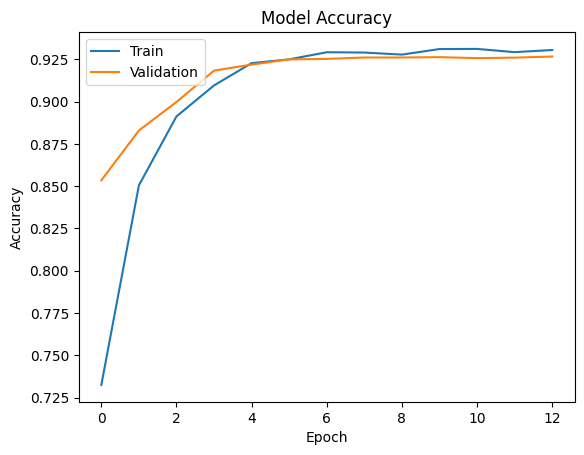

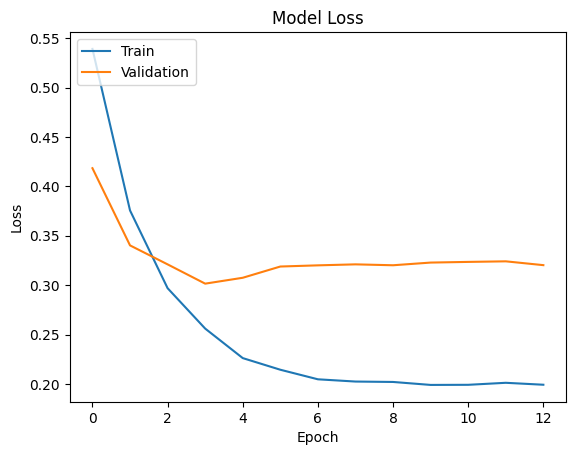

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get class predictions
test_pred = model.predict(test_set)
test_pred_classes = np.argmax(test_pred, axis=1)  # convert probabilities to class labels

# True classes
test_true_classes = test_set.classes  # already in correct format

# Compute confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'model' is not defined

In [ ]:
evaluation = model.evaluate(test_set)
print("Test Accuracy: {:.2f}%".format(evaluation[1] * 100))

In [ ]:
#Classification report
report = classification_report(test_true_classes, test_pred_classes, target_names=["Class 0", "Class 1"], labels=[0, 1], digits=4)

print("Classification Report:\n", report)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (class 1)
test_pred = model.predict(test_set)[:, 1]  # shape: (n_samples,)

# True class labels (0 or 1)
test_true_classes = test_set.classes  # shape: (n_samples,)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_true_classes, test_pred)
auc = roc_auc_score(test_true_classes, test_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



In [ ]:

from sklearn.metrics import precision_recall_curve, auc
# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(test_true_classes, test_pred_classes)

# Calculate the area under the precision-recall curve (AUC-PR)
auc_pr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(test_true_classes, test_pred_classes).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Sensitivity (True Positive Rate): {sensitivity:.4f}')
print(f'Specificity (True Negative Rate): {specificity:.4f}')